<a href="https://colab.research.google.com/github/davidfague/Neural-Modeling/blob/cleanup2/notebooks/L5PC_synaptic_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: https://mailmissouri-my.sharepoint.com/:w:/r/personal/drfrbc_umsystem_edu/Documents/Isaac%20synapse_tuner.docx?d=w74481c7e893e42b4b4782709409f4ed7&csf=1&web=1&e=yJlDvh

(1) be able to automatically tune Ben's synapses to match the in vivo data from the word doc (bullet #4.fig1.)

(2) replace the postsynaptic cell model with the L5 Cell (details under bullet #2)

(3) tune synaptic weight (initW) to match the experimental data's distribution of post-synaptic current magnitudes by region, type (#4.fig2.). To do so, implement gathering across segments of that region.

(4) tune Ziao's synapses to match the in-vivo data (#1,3)

(5) understand the differences between Ziao's synapses and Ben's synapses

## Pre-processing

Cloning repos

Moving modfiles

Compiling modfiles

Changing directory


In [1]:
!pip install neuron
# !pip install bmtool # don't install to use the forked repo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 30.3 MB/s eta 0:00:00


In [2]:
import neuron
from neuron import h

In [3]:
# clone the other repo for its modfiles
!git clone https://github.com/davidfague/Neural-Modeling.git

Cloning into 'Neural-Modeling'...
remote: Enumerating objects: 5067, done.
remote: Counting objects: 100% (2119/2119), done.
remote: Compressing objects: 100% (814/814), done.
remote: Total 5067 (delta 1462), reused 1898 (delta 1292), pack-reused 2948 (from 1)
Receiving objects: 100% (5067/5067), 54.42 MiB | 9.92 MiB/s, done.
Resolving deltas: 100% (3420/3420), done.
Updating files: 100% (427/427), done.


In [4]:
# clone the forked repo
!git clone https://github.com/davidfague/bmtool.git

Cloning into 'bmtool'...
remote: Enumerating objects: 1864, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 1864 (delta 187), reused 242 (delta 130), pack-reused 1525 (from 1)
Receiving objects: 100% (1864/1864), 12.76 MiB | 8.87 MiB/s, done.
Resolving deltas: 100% (1163/1163), done.


In [5]:
# move the modfiles from the other repo
# https://github.com/davidfague/Neural-Modeling/tree/cleanup2/modfiles/hay -> /content/bmtool/examples/synapses

!mv Neural-Modeling/modfiles/hay/* /content/bmtool/examples/synapses/modfiles/

In [6]:
import os
os.chdir('/content/bmtool/examples/synapses')

In [7]:
import sys
sys.path.append('../../bmtool/')

In [8]:
import bmtool

In [9]:
# having 2 h.vecstim objects seems to give an error & removing one of these seemed to fix
# !rm modfiles/vecevent_coreneuron.mod # keep this one assuming it is faster or more optimized or a later version that encompasses the other
!rm modfiles/vecevent.mod

In [10]:
# if already compiled then lets delete the folder and force a recompile
if os.path.isdir('modfiles/x86_64'):
    os.system("rm -rf modfiles/x86_64 ")
# compile the mod files
if not os.path.isdir("modfiles/x86_64"):
    os.chdir('modfiles')
    print(os.system("nrnivmodl"))
    os.chdir("..")


0


In [11]:
!nrnivmodl modfiles/

/usr/local/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/content/bmtool/examples/synapses
Mod files: "modfiles/modfiles//AMPA_NMDA.mod" "modfiles/modfiles//AMPA_NMDA_STP_LTP.mod" "modfiles/modfiles//AMPA_NMDA_STP.mod" "modfiles/modfiles//cadad.mod" "modfiles/modfiles//CaDynamics_E2.mod" "modfiles/modfiles//Ca_HVA.mod" "modfiles/modfiles//cal2.mod" "modfiles/modfiles//Ca_LVAst.mod" "modfiles/modfiles//can_mig.mod" "modfiles/modfiles//epsp.mod" "modfiles/modfiles//exp2syn_stp.mod" "modfiles/modfiles//GABA_AB.mod" "modfiles/modfiles//GABA_AB_STP.mod" "modfiles/modfiles//GABA_A_STP.mod" "modfiles/modfiles//gap.mod" "modfiles/modfiles//Gfluct.mod" "modfiles/modfiles//h_kole.mod" "modfiles/modfiles//Ih.mod" "modfiles/modfiles//imCA3.mod" "modfiles/modfiles//Im.mod" "modfiles/modfiles//int2pyr.mod" "modfiles/modfiles//kap_BS.mod" "modfiles/modfiles//kBK.mod" "mod

## Synapse definitions

synapse types and parameter defaults

In [12]:
general_settings = {
    'vclamp': False, # if vclamp should start on or off used mostly for singleEventv
    'rise_interval': (0.1, 0.9), #10-90%
    'tstart': 500., # when the singleEvent should start
    'tdur': 100.,    # Dur of sim after single synaptic event has occured
    'threshold': -15., #threshold for spike in mV
    'delay': 1.3, # netcon delay
    'weight': 1., # netcon weight
    'dt': 0.1, # 0.025 # simulation dt (ms)
    'celsius': 20 # temp of sim
}

conn_type_settings = {
    'blank': {
        'spec_settings': {

        },
        'spec_syn_param': {

        }
    },
    # -------------- Ziao Synapses --------------
        'LTS': { # inhibitory perisomatic
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "GABA_AB_STP",
        },
        'spec_syn_param': {
                'e_GABAA': -75.0,#-90.,
              'Use': 0.3,
              'Dep': 25.,
              'Fac': 100.
        }
    },
    'FSI': { # inhibitory perisomatic
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "GABA_AB_STP",
        },
        'spec_syn_param': {
                'e_GABAA': -75.0,#-90.,
                'Use': 0.3,
                'Dep': 400.,
                'Fac': 0.
        }
    },
    'CS2CP': { # excitatory choice
        'spec_settings': {
                                   'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "AMPA_NMDA_STP",
        },
        'spec_syn_param': {
              'tau_d_AMPA': 5.2,
              'Use': 0.41,
              'Dep': 532.,
              'Fac': 65.
        }
    },
    'CP2CP': { # excitatory choice
        'spec_settings': {
                                   'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "AMPA_NMDA_STP",
        },
        'spec_syn_param': {
                'tau_d_AMPA': 5.2,
                'Use': 0.37,
                'Dep': 31.7,
                'Fac': 519.
        }
    },
    # -------------- BEN SYNAPSES -------------- https://github.com/latimerb/L5NeuronSimulation/tree/master/L5NeuronSimulation/biophys_components/synaptic_models
    'PN2PN': { # exc
        'spec_settings': {
                        'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "pyr2pyrSUM",
        },
        'spec_syn_param': {
                "AlphaTmax_ampa": 5,
                "Beta_ampa": 0.5882,
                "Cdur_ampa": .2,
                "gbar_ampa": 0.001,
                "Erev_ampa": 0,
                "AlphaTmax_nmda": 3.4483,
                "Beta_nmda": 0.0233,
                "Cdur_nmda": 0.29,
                "gbar_nmda": 0.0005,
                "Erev_nmda": 0,
                "initW": .4375, #.4375 mean computed from lognormal distribution # default listed in a file was: 5,
                # "delay": 0.9,
                "tauD1": 35,
                "d1": 0.95,
                "tauD2": 250,
                "d2": 0.8,
                "tauF": 1,
                "f": 1
        }
    },
    'PV2PN': { # inhibitory perisomatic
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "int2pyr",
        },
        'spec_syn_param' : {
            "AlphaTmax_gaba": 1.52,
            "Beta_gaba": 0.14,
            "Cdur_gaba": 0.7254,
            "gbar_gaba": 1,
            "Erev_gaba": -75,
            "initW": 1, # default in ben file:1,
            "Wmax": 3,
            "Wmin": 0.25,
            # "delay": 2,
            # "con_pattern": 1,
            "lambda1": 1,
            "lambda2": 0.01,
            "threshold1": 0.5,
            "threshold2": 0.6,
            "tauD1": 40,
            "d1": 0.7,
            "tauD2": 500,
            "d2": 0.7,
            "tauF": 1,
            "f": 1
        }
    },
    'SOM2PN': { # inh dendritic
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "int2pyr",
        },
        'spec_syn_param': {
            "AlphaTmax_gaba": 1.52,
            "Beta_gaba": 0.14,
            "Cdur_gaba": 0.7254,
            "gbar_gaba": 0.006,
            "Erev_gaba": -75,
            "initW": 1,
            "Wmax": 3,
            "Wmin": 0.25,
            # "delay": 2,
            # "con_pattern": 1,
            "lambda1": 1,
            "lambda2": 0.01,
            "threshold1": 0.5,
            "threshold2": 0.6,
            "tauD1": 200,
            "d1": 0.8,
            "tauD2": 1,
            "d2": 1,
            "tauF": 1,
            "f": 1
        }
    },
    # --------------- Greg's -----------------------
    'Fac2FSI': { # facilitating synapse
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "AMPA_NMDA_STP",
        },
        'spec_syn_param': {
            'initW': 0.76,
            'tau_r_AMPA': 0.45,
            'tau_d_AMPA': 7.5,
            'Use': 0.13,
            'Dep': 0.,
            'Fac': 200.
        },
    },
    'Dep2FSI': { # depressing synapse
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'vclamp_amp': -55,
            'sec_x': 0.5,
            'sec_id':0,
            "level_of_detail": "GABA_A_STP",
        },
        'spec_syn_param': {
            'initW': 20,
            'tau_r_GABAA': 0.9,
            'tau_d_GABAA': 15,
            'e_GABAA':-75,
            'Use': 0.4,
            'Dep': 190.,
            'Fac': 0.
        },
    },

}

In [13]:
# # these are old news

# # some initW defaults that we had listed before using the .json parameters.
# inh_gmax_dist: float = 5#0.5
# soma_gmax_dist: float = 5#0.5
# apic_inh_gmax_dist: float = 2.8
# basal_inh_gmax_dist: float = 2.4

# # initW that seemed to work with the correct .json parameters (before adjusting gbar_gaba (from 1 to 0.006) for inh_perisomatic)
# inh_gmax_range_apic = [7.1]
# inh_gmax_range_dend = [0.0016]
# soma_gmax_range = [0.0025]

In [14]:
# connection = 'PN2PN'

# # sliders_to_use = ['initW','Dep','Fac','Use','tau_r_AMPA','tau_d_AMPA'] # greg
# sliders_to_use = ['initW',   'facfactor','f','F']#,'facfactor','P0g', 'fCag', 'lambda1', 'lambda2', 'threshold1', 'threshold2', 'tauCa', 'k', 'fmax', 'fmin']

# current_name = 'inmda' #'i'
# # NOTE sum iampa, inmda
# #igaba for int2pyr
# #inmda, iampa for pyrpyr
# #probably i_NMDA, i_AMPA for AMPA_NMDA_STP
# # probably i_GABA for GABA_AB_STP

# other_vars_to_record = []

## replacing the FSI_Cell with L5PCtemplate cell

In [15]:
# sys.path.append("/content/bmtool/bmtool/")
sys.path.append("/content/bmtool/bmtool/util/synapses.py")

In [16]:
# !nrnivmodl modfiles

In [17]:
# %ls x86_64/

In [18]:
# %ls modfiles/x86_64/

In [19]:
# h.nrn_load_dll('modfiles/x86_64/')

In [20]:
# testing values we generate
# import numpy as np
# def log_norm_dist(gmax_mean, gmax_std, gmax_scalar, size, clip):
#   val = np.random.lognormal(gmax_mean, gmax_std, size)
#   # print(val)
#   # print(np.clip(val, clip[0], clip[1]))
#   # print(float(np.clip(val, clip[0], clip[1])))
#   s = np.clip(val, clip[0], clip[1])
#   # s = gmax_scalar * float(np.clip(val, clip[0], clip[1]))
#   return s

# def precompute_bin_means(gmax_mean, gmax_std, gmax_scalar, clip, large_sample_size=10000):
#     # Generate a large number of log-normal distributed values
#     val = np.random.lognormal(gmax_mean, gmax_std, large_sample_size)
#     s = gmax_scalar * np.clip(val, clip[0], clip[1])

#     # Determine bins and compute the mean for each bin
#     num_bins = 10
#     bin_edges = np.percentile(s, np.linspace(0, 100, num_bins + 1))
#     bin_means = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)]

#     return bin_means

# def binned_log_norm_dist(gmax_mean, gmax_std, gmax_scalar, size, clip, bin_means):
#     # Generate log-normal distributed values
#     val = np.random.lognormal(gmax_mean, gmax_std, size)
#     # Clip the values
#     s = gmax_scalar * np.clip(val, clip[0], clip[1])
#     # Assign each value to the nearest bin mean
#     binned_values = np.zeros_like(s)
#     for i in range(size):
#         # Find the bin the value belongs to
#         bin_index = np.digitize(s[i], bin_means) - 1
#         # Assign the value to the bin mean
#         binned_values[i] = bin_means[bin_index]
#     return binned_values

# exc_mean = (np.log(0.45) - 0.5 * np.log((0.35/0.45)**2+1))
# exc_std = np.sqrt(np.log((0.35/0.45)**2 + 1))
# exc_clip = (0,5)
# exc_scalar = 1

# exc_gmax_values = log_norm_dist(exc_mean, exc_std, exc_scalar, 1000, exc_clip)

# binned_log_norm_dist = binned_log_norm_dist(exc_mean, exc_std, exc_scalar, 1000, exc_clip, precompute_bin_means(exc_mean, exc_std, exc_scalar, exc_clip))

# np.mean(exc_gmax_values)



# # prompt: compare the distributions of exc_gmax_values and binned_log_norm_dist

# import matplotlib.pyplot as plt

# # Create the histograms
# plt.hist(exc_gmax_values, bins=20, alpha=0.5, label='exc_gmax_values')
# plt.hist(binned_log_norm_dist, bins=20, alpha=0.5, label='binned_log_norm_dist')

# # Add labels and title
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Comparison of Distributions')

# # Add legend
# plt.legend(loc='upper right')

# # Show the plot
# plt.show()


In [21]:
neuron.load_mechanisms('modfiles/') # have to load the mechanisms to load L5PCbiophys3.hoc

True

In [22]:
use_hay_cell = True # overwrite the target cell
if use_hay_cell:
    for cell_type,items in conn_type_settings.items():
        conn_type_settings[cell_type]['spec_settings']['post_cell'] = 'L5PCtemplate'
        conn_type_settings[cell_type]['spec_settings']['sec_id'] = 0 # 0 will be soma; 1 would be a basal dendrite


    # hoc_files_to_load = ['stdrun.hoc', "../../../Neural-Modeling/cells/templates/L5PCbiophys3.hoc", 'import3d.hoc', "../../../Neural-Modeling/cells/templates/L5PCtemplate.hoc"]

    # needed for h.load_file("import3d.hoc")
    h.load_file('stdrun.hoc')

    # load procedure L5PCbiophys() for distributing biophys in h.L5PCtemplate()
    h.load_file("../../../Neural-Modeling/cells/templates/L5PCbiophys3.hoc") # cannot be loaded without loading mechanisms first

		# # load needed procedure for importing 3d coordinates
    h.load_file("import3d.hoc")

		# # # Load h.L5PCtemplate()
    h.load_file("../../../Neural-Modeling/cells/templates/L5PCtemplateMediumRes.hoc") # load template that gets biophys and establishes sectioning
    # called 'MediumRes' because semgentation is reverted back to original

    # path to 3d coords file that will be passed to "cell = h.L5PCtemplate(template_arg)" in SynapseTuner.set_up_cell(self)
    template_arg = "../../../Neural-Modeling/cells/templates/cell1.asc" # contains 3d coordinates
else:
    template_arg=None
    hoc_files_to_load = None

In [23]:
# have to unload the mechanisms or the synapse tuner throws an error
!rm -rf x86_64
!rm -rf modfiles/x86_64

## Initialize Synaptic Tuners

In [24]:
def InitializeSysnapseTuner(connection, current_name='i', other_vars_to_record=[], sliders_to_use=['initW'], template_arg=template_arg):
  from synapses import SynapseTuner
  mechanisms_dir = 'modfiles'
  templates_file = 'templates.hoc'

  tuner = SynapseTuner(mechanisms_dir=mechanisms_dir, # where x86_64 is located
                      templates_dir=templates_file, # where the neuron templates are located
                      conn_type_settings=conn_type_settings, # dict of connection settings
                      general_settings = general_settings, # dict of general settings
                      connection = connection, # key in connection settings for which connection you want to tune
                      #json_folder_path=json_folder_path, # If your network uses json files the path can be set to update the connection settings based on the keys and values in the json
                      current_name = current_name, # name of current variable in synapase
                      other_vars_to_record = other_vars_to_record, # Other synaptic variables you wish to record besides the normal ones
                      slider_vars=sliders_to_use,
                       template_arg=template_arg) # Range variables you want to tune to adjust synaptic response.
  return tuner

ben_synapses = True
if ben_synapses:
  tunerForEXC = InitializeSysnapseTuner(connection='PN2PN',
                                      current_name ='i',
                                      sliders_to_use=['initW', 'gbar_nmda','gbar_ampa'])
  tunerForInhPerisomatic =  InitializeSysnapseTuner(connection='PV2PN',
                                      current_name ='igaba',
                                      sliders_to_use=['initW', 'gbar_gaba'])
  tunerForInhDendritic =  InitializeSysnapseTuner(connection='SOM2PN',
                                      current_name ='igaba',
                                      sliders_to_use=['initW', 'gbar_gaba'])
else: # ziao synapses
  tunerForEXC = InitializeSysnapseTuner(connection='CS2CP',
                                      current_name ='i',
                                      sliders_to_use=['initW', 'tau_d_AMPA','Use','Dep','Fac'])
  tunerForEXC2 = InitializeSysnapseTuner(connection='CP2CP',
                                      current_name ='i',
                                      sliders_to_use=['initW', 'tau_d_AMPA','Use','Dep','Fac'])
  tunerForInhPerisomatic =  InitializeSysnapseTuner(connection='LTS',
                                      current_name ='i',
                                      sliders_to_use=['initW', 'tau_d_GABAA','Use','Dep','Fac'])
  tunerForInhDendritic =  InitializeSysnapseTuner(connection='FSI',
                                      current_name ='i',
                                      sliders_to_use=['initW', 'tau_d_GABAA','Use','Dep','Fac'])

NEURON mechanisms not found in modfiles.
NEURON mechanisms not found in modfiles.
NEURON mechanisms not found in modfiles.


In [25]:
tunerForEXC

In [26]:
  synapses = {
      'exc': tunerForEXC,
      'inhPerisomatic': tunerForInhPerisomatic,
      'inhDendritic': tunerForInhDendritic
  }

## Single event

(1) run to initialize input to the tuners

(2) check the mangitude of an individual post-synaptic-current (PSC)

In [27]:
# %ls

In [28]:
# h.load_file('templates.hoc')

In [29]:
# 'FSI_Cell' in dir(h)

In [30]:
# list(synapses['exc'].cell.all)[0]

In [31]:
# synapses['exc'].syn.get_segment()

In [32]:
# import numpy as np
# import matplotlib.pyplot as plt
# t = np.asarray(synapses['exc'].t)[np.asarray(synapses['exc'].t) > 490]
# v = np.asarray(synapses['exc'].soma_v)[np.asarray(synapses['exc'].t) > 490]
# plt.plot(t, v)

exc


/content/bmtool/examples/synapses/../../bmtool/synapses.py:328: RuntimeWarning: overflow encountered in exp
  popt, _ = curve_fit(lambda t, a, tau: a * np.exp(-t / tau), dt * np.arange(decay_len),


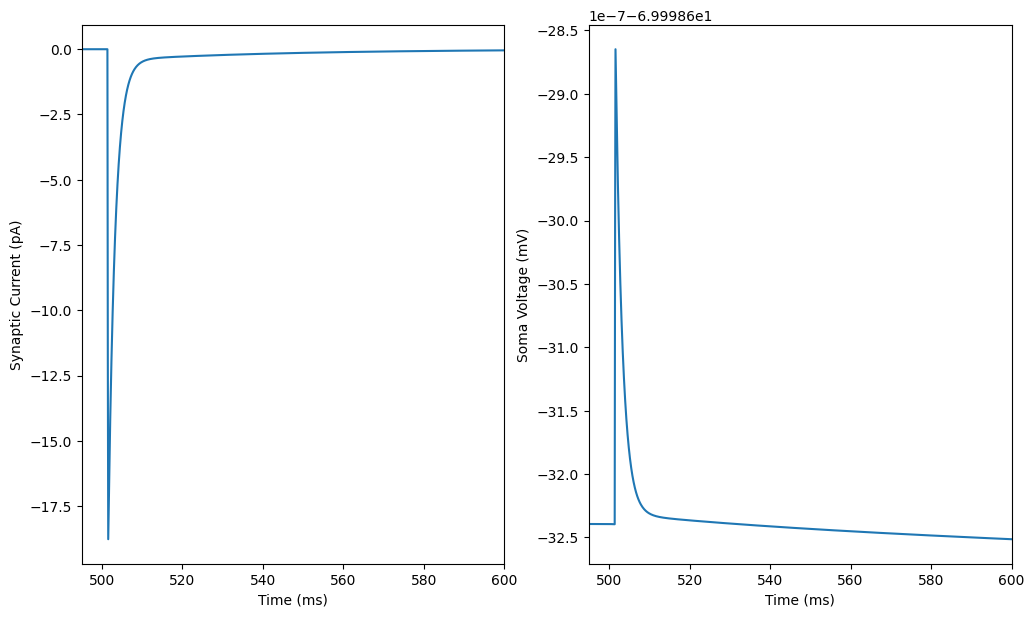

('baseline', -0.0)
('sign', -1.0)
('latency', 1.5)
('amp', 0.0187704044632415)
('rise_time', 0.1)
('decay_time', 1.8494892531939904)
('half_width', 2.8000000000000003)
Current Integral in pA*ms: -50.03
inhPerisomatic


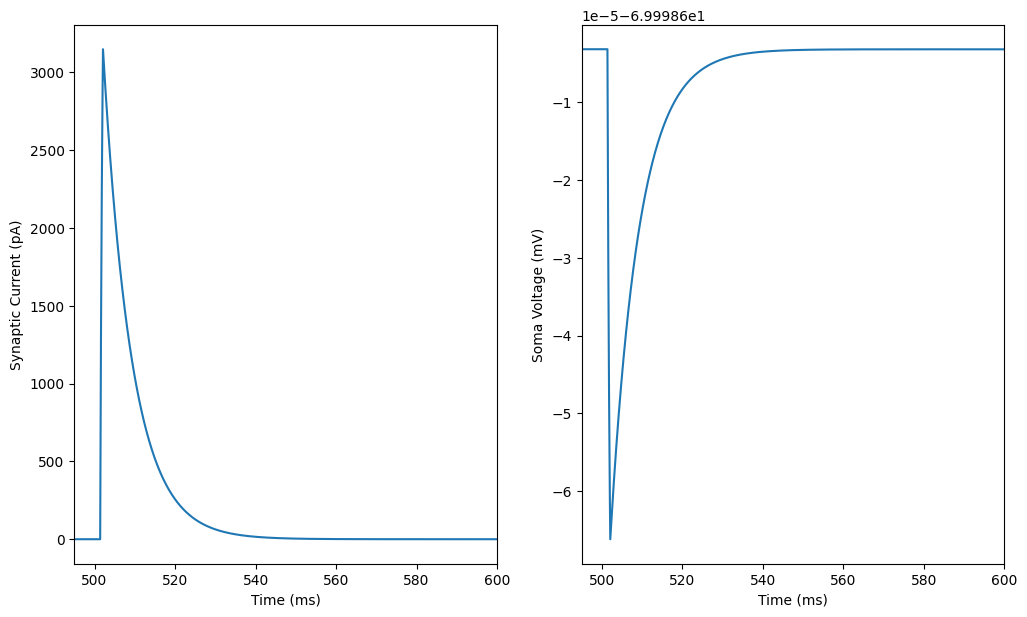

('baseline', 0.0)
('sign', 1.0)
('latency', 1.5)
('amp', 3.146785426753287)
('rise_time', 0.5)
('decay_time', 7.142897460076858)
('half_width', 6.800000000000001)
Current Integral in pA*ms: 23783.17
inhDendritic


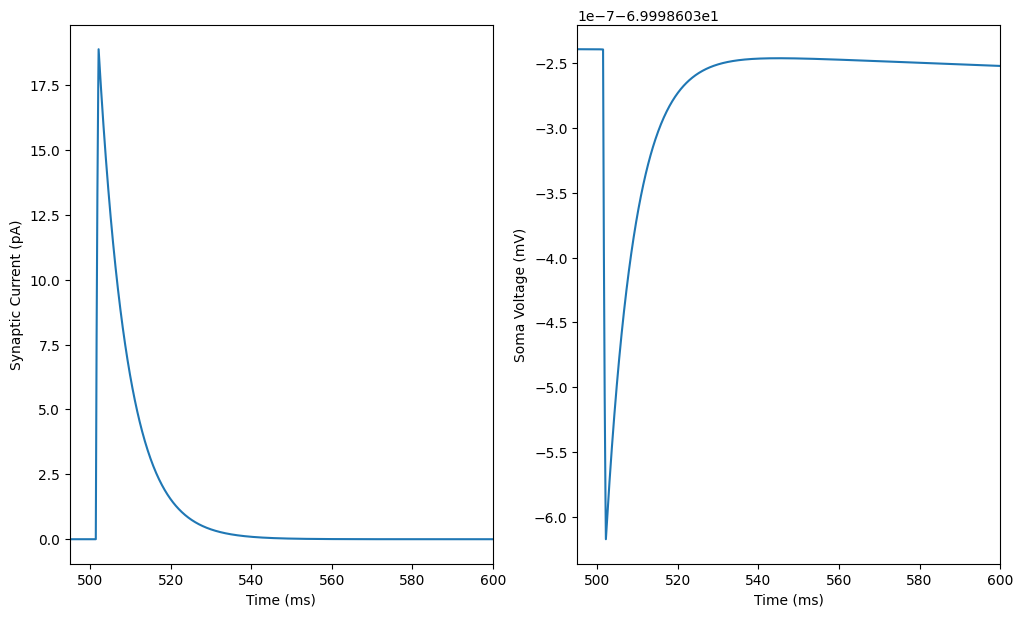

('baseline', 0.0)
('sign', 1.0)
('latency', 1.5)
('amp', 0.01888092918893173)
('rise_time', 0.5)
('decay_time', 7.142857383379123)
('half_width', 6.800000000000001)
Current Integral in pA*ms: 142.70


In [33]:
# have to run single_event to establish the input
for synapse_type,tuner in synapses.items():
  print(synapse_type)
  tuner.SingleEvent()

## Interactive Tuner

(1) select one of the synapse types

(2) check individual induction(input_freq) or PPR

(3) vary a parameter to understand how it affects the synapse

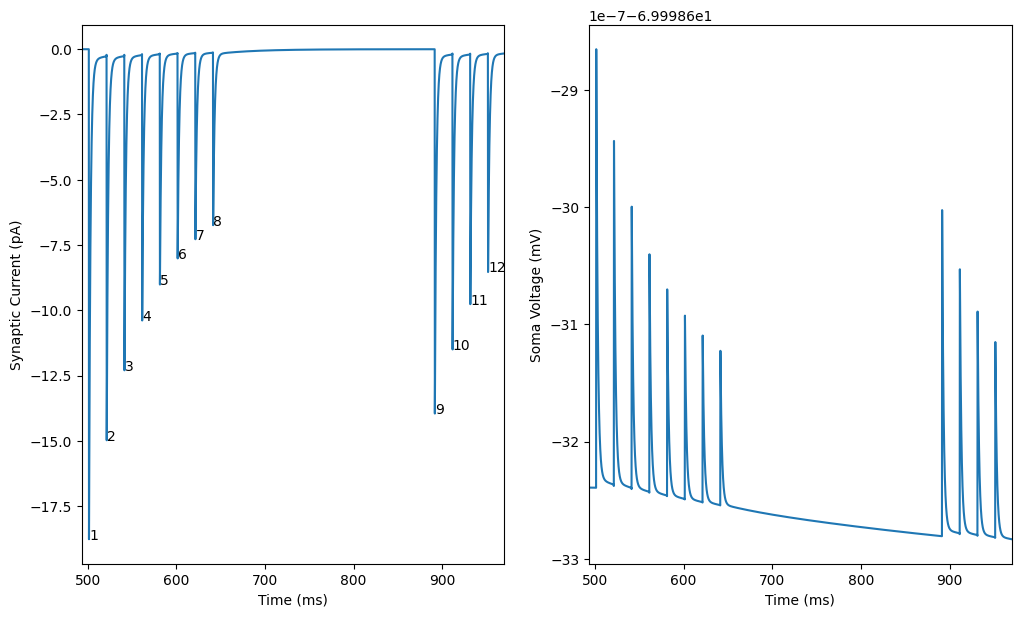

In [34]:
tuner_type = ['exc','inhPerisomatic','inhDendritic'][0] # select the first one
# alternatively synapses.keys(0)
print(tuner_type)
synapses[tuner_type].InteractiveTuner()

## Optimizer

(1) run to fit the value for (initW or gbar_{current_type} or others)

to the desired PSC magnitude (max ampltiude), PPR, and induction (from experimental data)

In [35]:
def auto(param_bounds, target_metrics, tuner):
  result = optimizer.optimize_parameters(
    target_metrics=target_metrics,
    param_bounds=param_bounds,
    init_guess='random', # either random or middle_guess. Random will start the synapse witha random value in the param_bound. Middle guess will pick the middle value in the param_bounds
    cost_function=custom_cost,
    method='SLSQP' # I believe this will be the fastest method, but you may try others check out https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.optimize.minimize.html
    )
  return result


Short Term Plasticity Results for 50Hz with 250 Delay
PPR: Above 1 is facilitating, below 1 is depressing.
Induction: Above 0 is facilitating, below 0 is depressing.
Recovery: A measure of how fast STP decays.

Paired Pulse Response (PPR)
Calculation: 2nd pulse / 1st pulse
Values: ([[14.98]]) / ([[18.77]]) = [[0.8]]

Induction
Calculation: (avg(6th, 7th, 8th pulses) - 1st pulse) / max amps
Values: avg([[8.01, 7.28, 6.74]]) - [[18.77]] / [18.77]
([7.34]) - ([18.77]) / [18.77] = -0.609

Recovery
Calculation: (avg(9th, 10th, 11th, 12th pulses) - avg(1st to 4th pulses)) / max amps
Values: avg([[13.96, 11.5 ,  9.77,  8.53]]) - avg([[18.77, 14.98, 12.3 , 10.39]]) / [18.77]
([10.94]) - ([14.11]) / [18.77] = -0.169




In [36]:
from synapses import SynapseOptimizer

In [37]:
# NOTE maybe change the frequency of input
# NOTE train frequency is new input parameter for optimizer which we can set to the mean in the table

run_optimizer=False

# CHOOSE specifications
tuner_type = ['exc','inhPerisomatic','inhDendritic'][0] # ex. select the first one # if these keys get out of line you can use synapses.keys()[N]
add_gbar_params = True

print(tuner_type)
optimizer = SynapseOptimizer(synapses[tuner_type])

# initialize param_bounds (parameters that can vary within the specified range)
param_bounds = {
    'initW': (0,synapses[tuner_type].conn['spec_syn_param']['initW']*10),
    # 'facfactor': (0, 400.0),
    # 'f': (0, 400.0),
    # 'F': (0, 400.0),
    # 'gbar_nmda': (0,4), # fix range, maybe dont use # change for gaba synapse
    # 'gbar_ampa': (0,1) # fix range, maybe dont use
}

# add variables to param_bounds with their ranges
if add_gbar_params:
  if 'pyr2pyr' in synapses[tuner_type].conn['spec_settings']['level_of_detail']:
    param_bounds['gbar_nmda'] = (0,synapses[tuner_type].conn['spec_syn_param']['gbar_nmda']*10) # up to 10x the default
    param_bounds['gbar_ampa'] = (0,synapses[tuner_type].conn['spec_syn_param']['gbar_ampa']*10) # up to 10x the default
  elif 'int2pyr' in synapses[tuner_type].conn['spec_settings']['level_of_detail']:
    param_bounds['gbar_gaba'] = (0,synapses[tuner_type].conn['spec_syn_param']['gbar_gaba']*10) #up to 10x the default


# define the target metrics
target_metrics = { # automatically selects based on tuner_type (need to be updated to match in vivo)
    'exc': {
            'induction': -0.75,
            'ppr': 0.8,
            'recovery': 0.0,
            'max_amplitude':25 #magnitude of PSC
    },
    'inhPerisomatic': {
            'induction': -0.75,
            'ppr': 0.8,
            'recovery': 0.0,
            'max_amplitude':25 #magnitude of PSC
    },
    'inhDendritic': {
            'induction': -0.75,
            'ppr': 0.8,
            'recovery': 0.0,
            'max_amplitude':25 #magnitude of PSC
    }
}

# currently the only metrics in the SynapseOptimizer are induction, prr, recovery, and max amplitude.
def custom_cost(metrics, targets):
    induction_error = (metrics['induction'] - targets['induction']) ** 2
    ppr_error = (metrics['ppr'] - targets['ppr']) ** 2
    recovery_error = (metrics['recovery'] - targets['recovery']) ** 2
    max_amp_errror = (metrics['max_amplitude'] - targets['max_amplitude']) ** 2
    # can weight each error term differently like this
    return induction_error + 3 * ppr_error + recovery_error + 0.5*max_amp_errror


# Run optimization with custom cost function
if run_optimizer:
  result = optimizer.optimize_parameters(
      target_metrics=target_metrics[tuner_type],
      param_bounds=param_bounds,
      init_guess='random', # either random or middle_guess. Random will start the synapse witha random value in the param_bound. Middle guess will pick the middle value in the param_bounds
      cost_function=custom_cost,
      method='SLSQP' # I believe this will be the fastest method, but you may try others check out https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.optimize.minimize.html
  )

  # Plot results
  optimizer.plot_optimization_results(result)

exc


After optimizing may need to update the variables in the original dictionary. (comment previous default)

## STP Frequency Response
Make sure that the induction/frequency curve matches in-vivo (fig 1. last column with
(1) compute induction/frequency to make sure it matches in-vivo

exc


Analyzing frequencies:   0%|          | 0/3 [00:00<?, ?it/s]

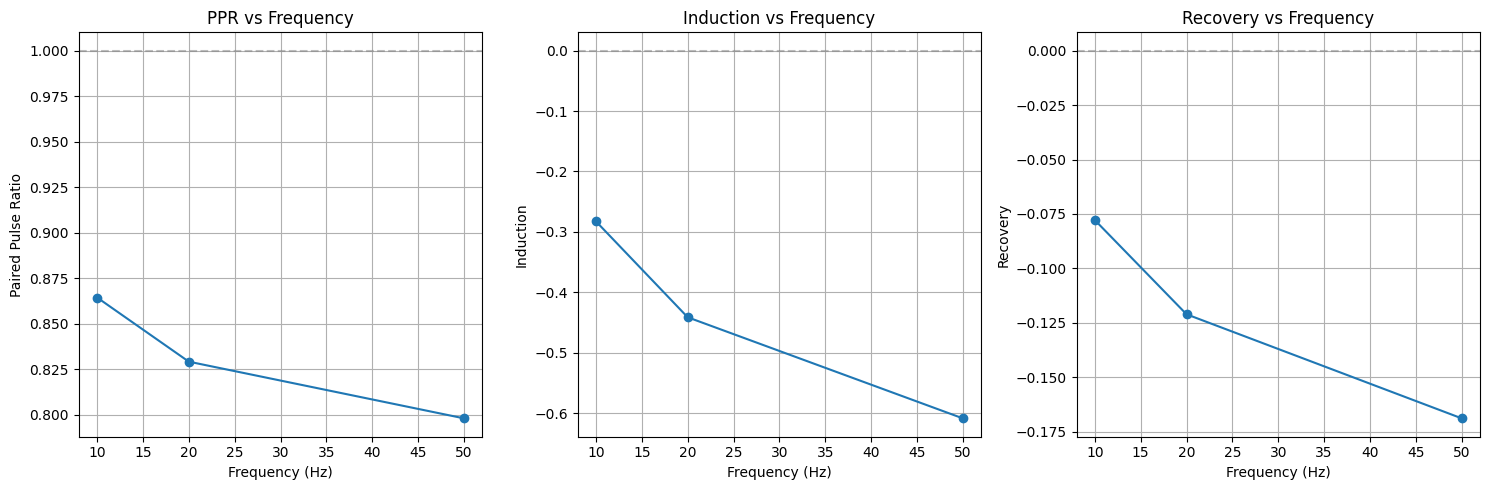

In [38]:
tuner_type = ['exc','inhPerisomatic','inhDendritic'][0] # select the first one
# alternatively synapses.keys(0)
print(tuner_type)
results = synapses[tuner_type].stp_frequency_response(log_plot = False, freqs=[10,20,50])

## record PSC magnitude distribution across sections

(1) specify region_type (section_type) and the synapse_type

(2) compute the mean,std of the magnitude of PSCs across the cell's sections of that type

In [39]:
# could make this into a function that just computes a dictionary so we only call it once and only creating/deleting a cell once.
# Could even pass the cell from the tuner instead of creating/deleting a new one.
def get_sec_ids_from_type(section_type):
  cell = h.L5PCtemplate("../../../Neural-Modeling/cells/templates/cell1.asc")

  if section_type == 'distal_apic': # distal apic (>100 microns from soma)
    sec_ids_to_use = [idx for idx,sec in enumerate(cell.all) if (sec in cell.apic) and (h.distance(cell.soma[0](0.5), sec(0.5)) > 100)]
  elif section_type == 'distal_basal': # distal basal dendrites (>100 microns from soma)
    sec_ids_to_use = [idx for idx,sec in enumerate(cell.all) if (sec in cell.dend) and (h.distance(cell.soma[0](0.5), sec(0.5)) > 100)]
  elif section_type == 'perisomatic': # proximal dendrites and soma  (within 100 microns of soma)
    sec_ids_to_use = [idx for idx,sec in enumerate(cell.all) if (h.distance(cell.soma[0](0.5), sec(0.5)) < 100)]
  else:
    del cell
    NotImplementedError(f"{section_type} not implemented for get_sec_ids_from_type")

  del cell
  return sec_ids_to_use

gather the post synaptic current magnitude at the middle of every section

In [40]:
#NOTE: adjust this so that we measure across the synapses's initW distribution.

import numpy as np
from synapses import SynapseTuner
import pandas as pd

measure_PSCs = False;

location_types_by_synapse_type = {
    'inhPerisomatic': ['perisomatic'],
    'exc': ['distal_basal', 'distal_apic'],
    'inhDendritic': ['distal_basal', 'distal_apic']
}

# Initialize an empty list to store results
results = []

if measure_PSCs:
  # gather distribution of PSC magnitudes for each synapse_type and location types
  for synapse_type, location_types in location_types_by_synapse_type.items():
    for location_type in location_types:
      # get the sections we need
      sec_ids_to_use = get_sec_ids_from_type(location_type) # select the type using integar

      # gather PSC magnitudes across locations
      magnitudes = []
      for sec_id_to_use in sec_ids_to_use:

        # move the synapse to the target location
        synapses[synapse_type].syn.loc(list(synapses[synapse_type].cell.all)[sec_id_to_use](0.5))

        #record magnitude of PSC
        PSC_mag = max(abs(tuner.SingleEvent(plot_and_print=False))) # NOTE: have to update to return
        magnitudes.append(PSC_mag) # have to fix this line

      # calc mean, std
      psc_mean = np.mean(magnitudes)
      psc_std = np.std(magnitudes)
      print(f"{synapse_type}\n")
      print(f"{location_type}\n")
      print(f" mean: {psc_mean}\n std:{psc_std} \n\n")

      # Store results in the list
      results.append({
          "Synapse Type": synapse_type,
          "Location Type": location_type,
          "PSC Mean": psc_mean,
          "PSC Std": psc_std
      })

# Convert the list to a DataFrame
results_df = pd.DataFrame(results)
# import ace_tools as tools
# tools.display_dataframe_to_user(name="PSC Data", dataframe=results_df)

In [ ]:
# gather PSC across different synaptic weights
measure_PSCs = True
num_weights_per_loc = 10

exc_mean = (np.log(0.45) - 0.5 * np.log((0.35/0.45)**2+1))
exc_std = np.sqrt(np.log((0.35/0.45)**2 + 1))
exc_clip = (0,5)

import numpy as np
def log_norm_dist(gmax_mean, gmax_std, size, clip): # exc
  val = np.random.lognormal(gmax_mean, gmax_std, size)
  # print(val)
  # print(np.clip(val, clip[0], clip[1]))
  # print(float(np.clip(val, clip[0], clip[1])))
  s = np.clip(val, clip[0], clip[1])
  # s = gmax_scalar * float(np.clip(val, clip[0], clip[1]))
  return s

location_types_by_synapse_type = {
    # 'inhPerisomatic': ['perisomatic'],
    'exc': ['distal_basal', 'distal_apic'],
    # 'inhDendritic': ['distal_basal', 'distal_apic']
}


# Initialize an empty list to store results
results = []

if measure_PSCs:
  # gather distribution of PSC magnitudes for each synapse_type and location types
  for synapse_type, location_types in location_types_by_synapse_type.items():
    for location_type in location_types:
      # get the sections we need
      sec_ids_to_use = get_sec_ids_from_type(location_type) # select the type using integar

      # gather PSC magnitudes across locations
      magnitudes = []

      for sec_id_to_use in sec_ids_to_use:
        # move the synapse to the target location
        synapses[synapse_type].syn.loc(list(synapses[synapse_type].cell.all)[sec_id_to_use](0.5))

        for i_weight in range(num_weights_per_loc):
          new_weight = log_norm_dist(exc_mean, exc_std, 1, exc_clip)
          synapses['exc'].syn.initW = new_weight

          #record magnitude of PSC
          PSC_mag = max(abs(tuner.SingleEvent(plot_and_print=False))) # NOTE: have to update to return
          magnitudes.append(PSC_mag) # have to fix this line

      # calc mean, std
      psc_mean = np.mean(magnitudes)
      psc_std = np.std(magnitudes)
      print(f"{synapse_type}\n")
      print(f"{location_type}\n")
      print(f" mean: {psc_mean}\n std:{psc_std} \n\n")

      # Store results in the list
      results.append({
          "Synapse Type": synapse_type,
          "Location Type": location_type,
          "PSC Mean": psc_mean,
          "PSC Std": psc_std
      })

# Convert the list to a DataFrame
results_df = pd.DataFrame(results)
# import ace_tools as tools
# tools.display_dataframe_to_user(name="PSC Data", dataframe=results_df)

<ipython-input-41-f6ec9d5c4f66>:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  synapses['exc'].syn.initW = new_weight


In [ ]:
results_df

In [ ]:
# synapses['exc'].syn.initW

In [ ]:
# looks like building the cell worked.
# # check cell properties
# sec_id = 100
# print(f"{list(synapses['exc'].cell.all)[sec_id](0.5)}: {dir(list(synapses['exc'].cell.all)[sec_id](0.5))}")

In [ ]:
# print(f"{list(synapses['exc'].cell.all)[sec_id](0.5).Ca_HVA.gCa_HVAbar}: {dir(list(synapses['exc'].cell.all)[sec_id](0.5).Ca_HVA.gCa_HVAbar)}")